In [1]:
# preprocessing
import pandas as pd
from preprocess import preprocess_data, stratify_plot

# DL
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dl import MultiHeadNN, train, test, evaluate, evaluate_plot

# ML
from preprocess import preprocess_data, stratify_plot, stratify_stack_plot
from ml import check_transfer, choose_model, featureplot, afterSMOTE_models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pickle

import warnings
warnings.filterwarnings("ignore")

## preprocess

(199, 4659) (25, 4659) (199, 5) (25, 5)


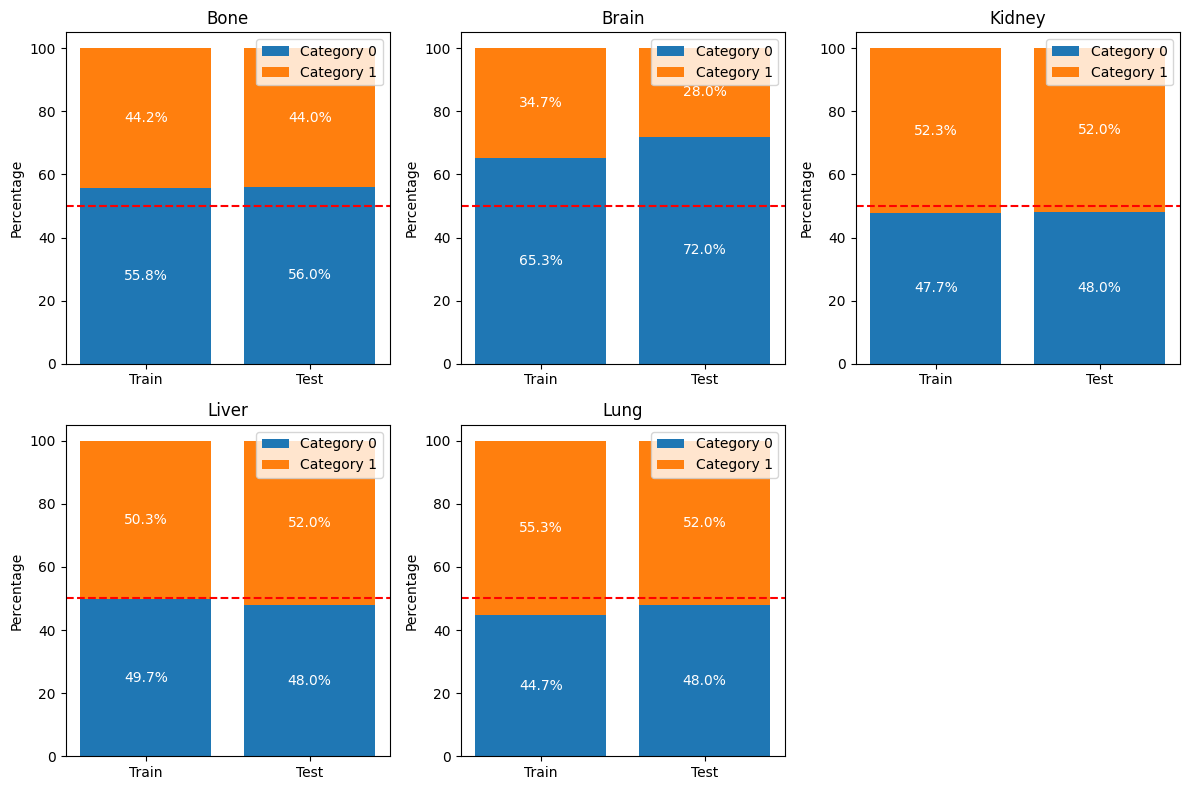

In [2]:
# 載入資料
genes_path = 'Metastasis/genes.csv'
meta_path = 'Metastasis/metabolites.csv'
resp_path = 'Metastasis/Response.csv'

# 處理資料
X_train, X_test, y_train, y_test, colnames = preprocess_data(genes_path, meta_path, resp_path, stratify=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
cancers = ['Bone', 'Brain', 'Kidney', 'Liver', 'Lung']

# 切分資料集後 有轉移&無轉移的比例
stratify_stack_plot(y_train, y_test) 

## DL

In [55]:
# 超參數 
shared = 128 # 共享層維度
num_epochs = 200
batch_size = 4
trytry = 1 # 第幾次測試

# 轉換為 PyTorch 張量
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()

# 初始化模型、損失函數和優化器
model = MultiHeadNN(input_dim=X_train_tensor.shape[1], shared_dim=shared, output_dim=1)
criterion = nn.BCEWithLogitsLoss() # sigmoid + BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [11]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MultiHeadNN                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       596,480
│    └─ReLU: 2-2                         --
├─Linear: 1-2                            129
├─Linear: 1-3                            129
├─Linear: 1-4                            129
├─Linear: 1-5                            129
├─Linear: 1-6                            129
Total params: 597,125
Trainable params: 597,125
Non-trainable params: 0

In [56]:
# 開始訓練
performance_history = []
loss_history = []
for epoch in range(num_epochs):
    # 訓練模型
    loss = train(model, X_train_tensor, y_train_tensor, criterion, optimizer, batch_size)
    # 測試模型
    outputs = test(model, X_test_tensor)
    # 評估模型
    epoch_metrics = evaluate(outputs, y_test_tensor.cpu().numpy(), cancers)
    
    loss_history.append(loss)
    performance_history.append(epoch_metrics)
    formatted_auc = ', '.join([f"{i}: {epoch_metrics[i]['AUC']:.4f}" for i in epoch_metrics.keys()])
    print(f'【Epoch】{epoch+1}/{num_epochs}, 【Train Loss】{loss:.4f}, 【Test AUC】{formatted_auc}')


# 儲存模型
torch.save(model, f'model/{trytry}_model.pt')
print(f"已儲存模型至model/{trytry}_model.pt")

# 匯入模型
# model = torch.load('model/1_model.pt')

【Epoch】1/200, 【Train Loss】1.3957, 【Test AUC】Bone: 0.4935, Brain: 0.5159, Kidney: 0.5962, Liver: 0.6410, Lung: 0.4744
【Epoch】2/200, 【Train Loss】1.0345, 【Test AUC】Bone: 0.6299, Brain: 0.5397, Kidney: 0.5385, Liver: 0.6410, Lung: 0.3974
【Epoch】3/200, 【Train Loss】0.9060, 【Test AUC】Bone: 0.6818, Brain: 0.5556, Kidney: 0.5705, Liver: 0.6667, Lung: 0.3718
【Epoch】4/200, 【Train Loss】0.8303, 【Test AUC】Bone: 0.6688, Brain: 0.5556, Kidney: 0.5769, Liver: 0.6987, Lung: 0.3846
【Epoch】5/200, 【Train Loss】0.7527, 【Test AUC】Bone: 0.5909, Brain: 0.5476, Kidney: 0.6026, Liver: 0.6987, Lung: 0.4295
【Epoch】6/200, 【Train Loss】0.7719, 【Test AUC】Bone: 0.6429, Brain: 0.6270, Kidney: 0.6218, Liver: 0.7115, Lung: 0.4423
【Epoch】7/200, 【Train Loss】0.7551, 【Test AUC】Bone: 0.6104, Brain: 0.5794, Kidney: 0.6474, Liver: 0.7115, Lung: 0.4872
【Epoch】8/200, 【Train Loss】0.7234, 【Test AUC】Bone: 0.6429, Brain: 0.6111, Kidney: 0.5833, Liver: 0.7115, Lung: 0.5256
【Epoch】9/200, 【Train Loss】0.7048, 【Test AUC】Bone: 0.6234, Brain:

已儲存圖片至plot/lossAUC_1.png
已儲存圖片至plot/other_1.png


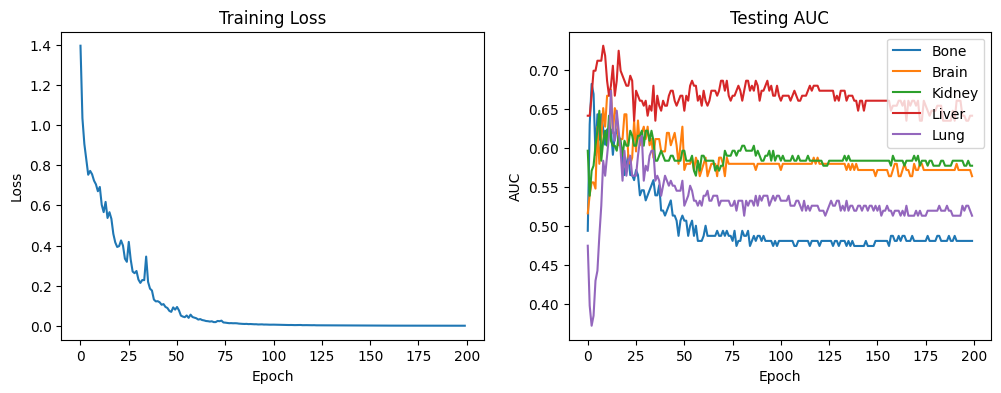

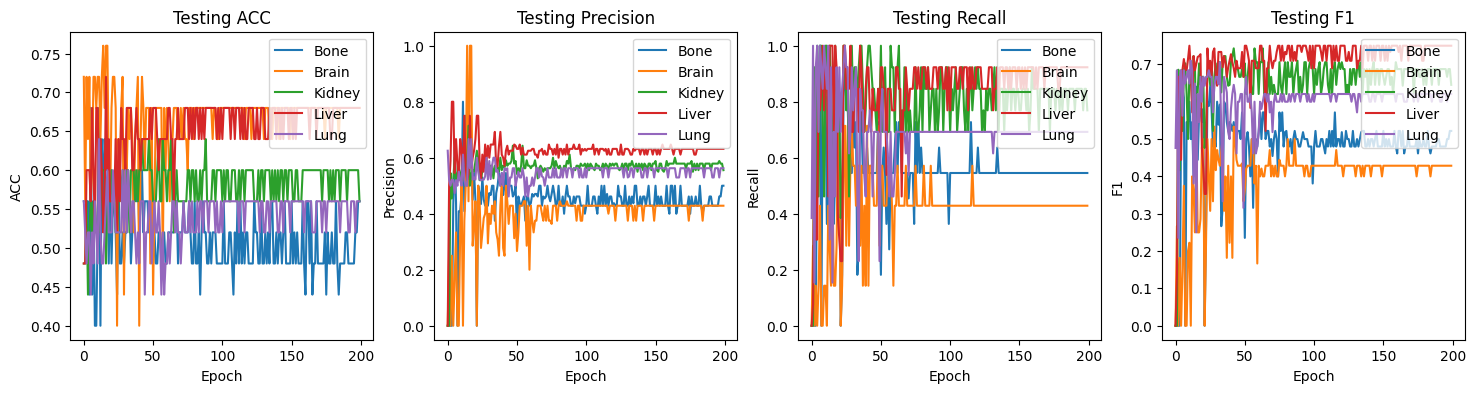

In [57]:
# 繪製Loss, AUC
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss")
plt.subplot(1, 2, 2)
evaluate_plot(performance_history, "AUC", cancers)

plt.savefig(f'plot/lossAUC_{trytry}.png', dpi=300)
print(f"已儲存圖片至plot/lossAUC_{trytry}.png")


# 繪製ACC, Precision, Recall, F1
plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
evaluate_plot(performance_history, "ACC", cancers)
plt.subplot(1, 4, 2)
evaluate_plot(performance_history, "Precision", cancers)
plt.subplot(1, 4, 3)
evaluate_plot(performance_history, "Recall", cancers)
plt.subplot(1, 4, 4)
evaluate_plot(performance_history, "F1", cancers)

plt.savefig(f'plot/other_{trytry}.png', dpi=300)
print(f"已儲存圖片至plot/other_{trytry}.png")

## ML

In [6]:
# 決策樹
print('Decision Tree')
dt_results = check_transfer(X_train, X_test, y_train, y_test, "DecisionTree")
dt_results

Decision Tree


,Accuracy,Precision,Recall,F1,AUC
Bone,0.48,0.3750,0.2727,0.3158,0.4578
Brain,0.52,0.2222,0.2857,0.2500,0.4484
Kidney,0.32,0.3750,0.4615,0.4138,0.3141
Liver,0.60,0.6154,0.6154,0.6154,0.5994
Lung,0.52,0.5385,0.5385,0.5385,0.5192


In [7]:
# 隨機森林
print('Random Forest')
rf_results = check_transfer(X_train, X_test, y_train, y_test, "RandomForest")
rf_results

Random Forest


,Accuracy,Precision,Recall,F1,AUC
Bone,0.64,0.6250,0.4545,0.5263,0.6656
Brain,0.68,0.3333,0.1429,0.2000,0.4206
Kidney,0.64,0.6111,0.8462,0.7097,0.7115
Liver,0.52,0.5333,0.6154,0.5714,0.6538
Lung,0.40,0.4444,0.6154,0.5161,0.3622


In [3]:
# LightGBM
print('LightGBM')
lgbm_results = check_transfer(X_train, X_test, y_train, y_test, "LightGBM") # 於server上運算
# lgbm_results = pd.read_csv('result/LightGBM_transfer.csv', index_col=0)
lgbm_results

LightGBM


,Accuracy,Precision,Recall,F1,AUC
Bone,0.56,0.5000,0.6364,0.5600,0.5455
Brain,0.48,0.1250,0.1429,0.1333,0.4206
Kidney,0.52,0.5238,0.8462,0.6471,0.5577
Liver,0.60,0.6154,0.6154,0.6154,0.5833
Lung,0.48,0.5000,0.7692,0.6061,0.5577


In [4]:
# CatBoost
print('CatBoost')
catb_results = check_transfer(X_train, X_test, y_train, y_test, "CatBoost") # 於server上運算
# catb_results = pd.read_csv('result/CatBoost_transfer.csv', index_col=0)
catb_results

CatBoost


,Accuracy,Precision,Recall,F1,AUC
Bone,0.56,0.5000,0.5455,0.5217,0.6299
Brain,0.64,0.3333,0.2857,0.3077,0.4921
Kidney,0.48,0.5000,0.8462,0.6286,0.5897
Liver,0.52,0.5333,0.6154,0.5714,0.5897
Lung,0.48,0.5000,0.7692,0.6061,0.5641


In [12]:
# SMOTE (只做Brain部位)
smote = SMOTE(random_state=0, sampling_strategy=0.8)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train[:,1])

print('Brain')
print(f'原資料: 轉移 {np.bincount(y_train[:,1])[0]}, 沒轉移 {np.bincount(y_train[:,1])[1]} ')
print(f"SMOTE後: 轉移 {np.bincount(y_train_smote)[0]}, 沒轉移 {np.bincount(y_train_smote)[1]} ")

models = ['DecisionTree', 'RandomForest', 'LightGBM', 'CatBoost']
smo_df = afterSMOTE_models(models, 'Brain', X_train_smote, X_test, y_train_smote, y_test) # 於server上運算

# smo_df = pd.read_csv('result/Brain_smote.csv', index_col=0)
smo_df
# 2m

Brain
原資料: 轉移 130, 沒轉移 69 
SMOTE結果: 轉移 130, 沒轉移 104 


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
DecisionTree,0.48,0.3750,0.2727,0.3158,0.4578
RandomForest,0.72,0.8333,0.4545,0.5882,0.7695
LightGBM,0.60,0.5714,0.3636,0.4444,0.6558
CatBoost,0.68,0.7143,0.4545,0.5556,0.6234


In [14]:
# 選擇AUC最高的模型
df = choose_model(dt_results, rf_results, lgbm_results, catb_results, smo_df)
df

,Bone,Brain,Kidney,Liver,Lung
Accuracy,0.64,0.72,0.64,0.52,0.48
Precision,0.625,0.8333,0.6111,0.5333,0.5
Recall,0.4545,0.4545,0.8462,0.6154,0.7692
F1,0.5263,0.5882,0.7097,0.5714,0.6061
AUC,0.6656,0.7695,0.7115,0.6538,0.5641
Source,RandomForest,RandomForest_Smote,RandomForest,RandomForest,CatBoost


In [3]:
# 匯入模型 查看特徵重要性
# Bone-LightGBM
# Brain-RandomForest_Smote, 
# Kidney-DecisionTree, 
# Liver-RandomForest, 
# Lung-LightGBM 

with open('model/Bone_RandomForest.pkl', 'rb') as file:
    RandomForest_Bone = pickle.load(file)
with open('model/Brain_RandomForest_smote.pkl', 'rb') as file:
    RandomForest_Brain = pickle.load(file)
with open('model/Kidney_RandomForest.pkl', 'rb') as file:
    RandomForest_Kidney = pickle.load(file)
with open('model/Liver_RandomForest.pkl', 'rb') as file:
    RandomForest_Liver = pickle.load(file)
with open('model/Lung_CatBoost.pkl', 'rb') as file:
    CatBoost_Lung = pickle.load(file)

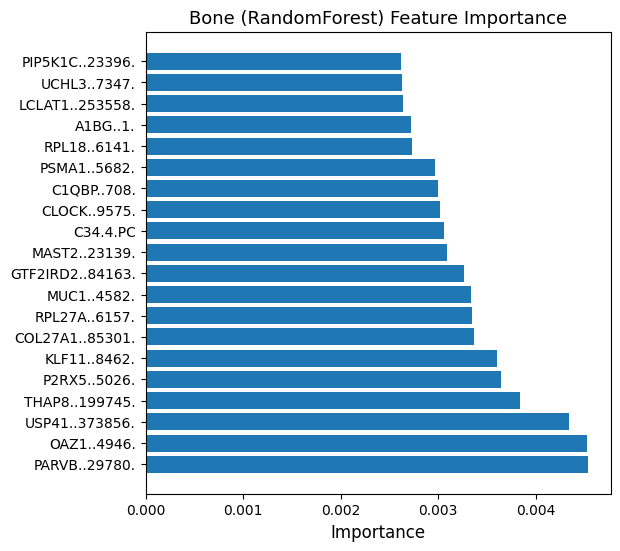

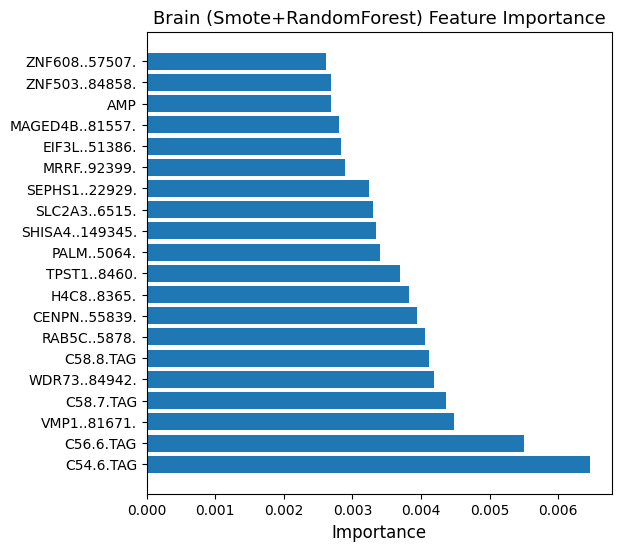

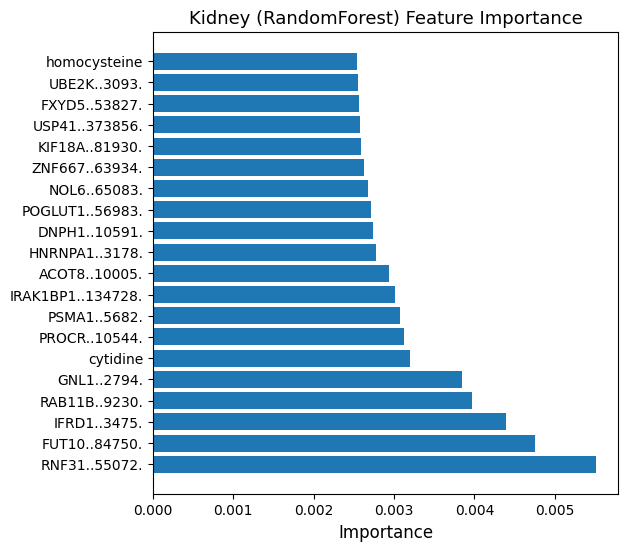

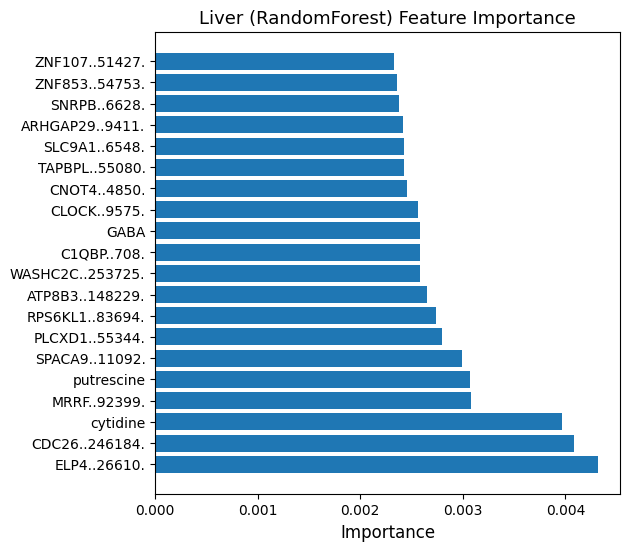

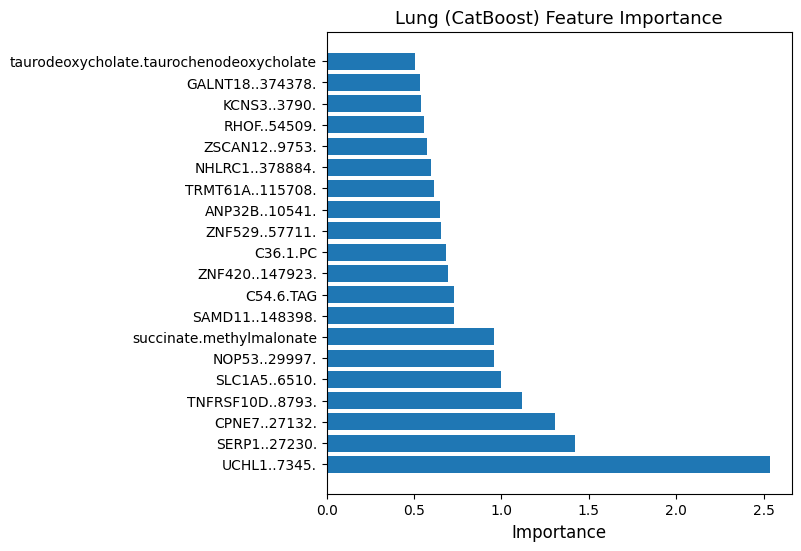

In [5]:
# 重要變數
featureplot(RandomForest_Bone.feature_importances_,20, colnames, "Bone (RandomForest) Feature Importance")
featureplot(RandomForest_Brain.feature_importances_,20, colnames, "Brain (Smote+RandomForest) Feature Importance")
featureplot(RandomForest_Kidney.feature_importances_,20, colnames, "Kidney (RandomForest) Feature Importance")
featureplot(RandomForest_Liver.feature_importances_,20, colnames, "Liver (RandomForest) Feature Importance")
featureplot(CatBoost_Lung.feature_importances_,20, colnames, "Lung (CatBoost) Feature Importance")